# Modular Neural Network Implementation

## Import the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Process the Dataset

Load, Shuffle, Split, Normalise Dataset

In [2]:
data = pd.read_csv('data/train.csv') # Load MNIST training data (label in first column, pixels after)

In [3]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
data = np.array(data) # Convert to numpy array for faster computation

# m = number of examples
# n = number of features + label
m,n = data.shape

In [5]:
np.random.shuffle(data) # Shuffle data to avoid learning order bias

# Split data into development and training sets
data_dev = data[0:1000].T
data_train = data[1000:m].T

# Separate labels (Y) and features (X)
Y_dev = data_dev[0]
X_dev = data_dev[1:n]  / 255. # Values are divided by 255 to scale them between 0 and 1 - Pixel Normalization
Y_train = data_train[0]
X_train = data_train[1:n]  / 255.

## Neural Network Implementation

### Activation Functions Used

In [ ]:
# ReLU activation: max(0, Z) i.e. z if z>0 else 0

def relu(Z):
    return np.maximum(0, Z)

In [ ]:
# Softmax activation for multi-class classification.
# Provides a probability distribution over classes and totals to 1.

def softmax(Z):
    Z_shift = Z - np.max(Z, axis=0, keepdims=True)
    exp_Z = np.exp(Z_shift)
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

### Utility functions used in calculations

In [ ]:
# Derivative of ReLU for backpropagation
# Compensate for non-linearity introduced by ReLU activation while computing gradients

def relu_backward(dA, Z):
    dZ = dA.copy()
    dZ[Z <= 0] = 0
    return dZ

In [ ]:
# Cross-entropy loss for multi-class classification
# AL : softmax probabilities (10, m)
#Y  : one-hot encoded labels (10, m)

def cross_entropy_loss(AL, Y):
    m = Y.shape[1]
    loss = -np.sum(Y * np.log(AL + 1e-8)) / m
    return loss

In [ ]:
# Convert labels into one-hot encoded vectors.
# Example: 3 -> [0,0,0,1,0,0,0,0,0,0]

def one_hot_encode(y, num_classes):
    m = y.shape[0]
    one_hot = np.zeros((num_classes, m))
    one_hot[y, np.arange(m)] = 1
    return one_hot

In [ ]:
# Computes classification accuracy
# AL : softmax outputs
#Y  : one-hot encoded labels

def compute_accuracy(AL, Y):
    preds = np.argmax(AL, axis=0)
    labels = np.argmax(Y, axis=0)
    return np.mean(preds == labels)

### Function to initialise the weights and biases for the layers

In [ ]:
# Initializes weights using He initialization
# Biases initialized to zero

def initialize_parameters(layer_dims):
    parameters = {}
    L = len(layer_dims) - 1

    for l in range(1, L + 1):
        parameters[f"W{l}"] = np.random.randn(
            layer_dims[l], layer_dims[l - 1]
        ) * np.sqrt(2.0 / layer_dims[l - 1])

        parameters[f"b{l}"] = np.zeros((layer_dims[l], 1))

    return parameters

### Forward Propagation

In [ ]:
# Performs forward pass through the network
# Stores intermediate values for backpropagation

def forward_propagation(X, parameters):
    caches = {}
    A = X
    L = len(parameters) // 2

    # Hidden layers with ReLU activation
    for l in range(1, L):
        Z = parameters[f"W{l}"] @ A + parameters[f"b{l}"]
        A = relu(Z)

        caches[f"Z{l}"] = Z
        caches[f"A{l}"] = A
    
    # Output layer with Softmax activation
    ZL = parameters[f"W{L}"] @ A + parameters[f"b{L}"]
    AL = softmax(ZL)

    caches[f"Z{L}"] = ZL
    caches[f"A{L}"] = AL

    return AL, caches

### Backward Propagation

In [ ]:
# Computes gradients for all parameters using backpropagation

def backward_propagation(X, Y, parameters, caches):
    grads = {}
    m = X.shape[1]
    L = len(parameters) // 2

    # Output layer gradient (Softmax + Cross-Entropy)
    dZ = caches[f"A{L}"] - Y
    grads[f"dW{L}"] = (1 / m) * dZ @ caches[f"A{L-1}"].T
    grads[f"db{L}"] = (1 / m) * np.sum(dZ, axis=1, keepdims=True)

    dA_prev = parameters[f"W{L}"].T @ dZ

    # Hidden layers gradients (ReLU)
    for l in reversed(range(1, L)):
        Z = caches[f"Z{l}"]
        dZ = relu_backward(dA_prev, Z)

        A_prev = X if l == 1 else caches[f"A{l-1}"]

        grads[f"dW{l}"] = (1 / m) * dZ @ A_prev.T
        grads[f"db{l}"] = (1 / m) * np.sum(dZ, axis=1, keepdims=True)

        dA_prev = parameters[f"W{l}"].T @ dZ

    return grads

### Parameters Updation

In [ ]:
# Updates weights and biases using gradient descent

def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2

    for l in range(1, L + 1):
        parameters[f"W{l}"] -= learning_rate * grads[f"dW{l}"]
        parameters[f"b{l}"] -= learning_rate * grads[f"db{l}"]

    return parameters

### Training Loop

In [ ]:
# Trains the neural network using full-batch gradient descent

def train(X, Y, layer_dims, learning_rate=0.01, epochs=1000, print_loss=True, print_accuracy=True):
    parameters = initialize_parameters(layer_dims)

    for epoch in range(epochs):
        AL, caches = forward_propagation(X, parameters)
        loss = cross_entropy_loss(AL, Y)
        acc = compute_accuracy(AL, Y)
        grads = backward_propagation(X, Y, parameters, caches)
        parameters = update_parameters(parameters, grads, learning_rate)

        if print_loss and print_accuracy and epoch % 50 == 0:
            print(f"Epoch {epoch} | Loss: {loss:.4f} | Accuracy: {acc*100:.2f}%")

    return parameters

## Testing Utility Functions

In [ ]:
# Runs inference on a single image and visualizes it

def test_prediction(index, X, Y, parameters):

    x = X[:, index:index+1]

    AL, _ = forward_propagation(x, parameters)

    prediction = np.argmax(AL, axis=0)[0]
    label = Y[index]

    print("Prediction:", prediction)
    print("Label:", label)

    image = x.reshape(28, 28)
    plt.gray()
    plt.imshow(image, interpolation='nearest')
    plt.axis("off")
    plt.show()

In [18]:
def predict(X, parameters):
    AL, _ = forward_propagation(X, parameters)
    return np.argmax(AL, axis=0)

## Model Setup and Training

In [19]:
layer_dims = [784, 128, 64, 10]

In [20]:
num_classes = 10

Y_train_oh = one_hot_encode(Y_train, num_classes)
Y_dev_oh   = one_hot_encode(Y_dev, num_classes)

In [21]:
parameters = train(X_train, Y_train_oh, layer_dims, learning_rate=0.03, epochs=1000)

Epoch 0 | Loss: 2.5633 | Accuracy: 9.10%
Epoch 50 | Loss: 1.2498 | Accuracy: 70.79%
Epoch 100 | Loss: 0.7285 | Accuracy: 82.77%
Epoch 150 | Loss: 0.5494 | Accuracy: 86.18%
Epoch 200 | Loss: 0.4672 | Accuracy: 87.67%
Epoch 250 | Loss: 0.4197 | Accuracy: 88.60%
Epoch 300 | Loss: 0.3880 | Accuracy: 89.25%
Epoch 350 | Loss: 0.3648 | Accuracy: 89.85%
Epoch 400 | Loss: 0.3467 | Accuracy: 90.30%
Epoch 450 | Loss: 0.3321 | Accuracy: 90.68%
Epoch 500 | Loss: 0.3197 | Accuracy: 90.98%
Epoch 550 | Loss: 0.3091 | Accuracy: 91.25%
Epoch 600 | Loss: 0.2997 | Accuracy: 91.51%
Epoch 650 | Loss: 0.2913 | Accuracy: 91.76%
Epoch 700 | Loss: 0.2836 | Accuracy: 91.97%
Epoch 750 | Loss: 0.2765 | Accuracy: 92.15%
Epoch 800 | Loss: 0.2700 | Accuracy: 92.35%
Epoch 850 | Loss: 0.2638 | Accuracy: 92.51%
Epoch 900 | Loss: 0.2580 | Accuracy: 92.69%
Epoch 950 | Loss: 0.2526 | Accuracy: 92.83%


## Testing Phase

Prediction: 1
Label: 8


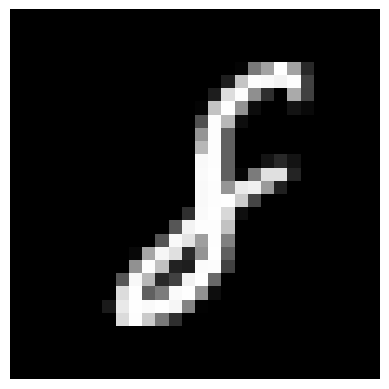

Prediction: 5
Label: 5


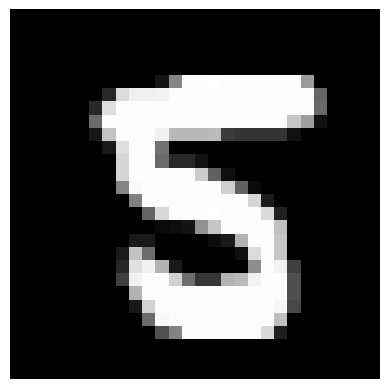

Prediction: 1
Label: 1


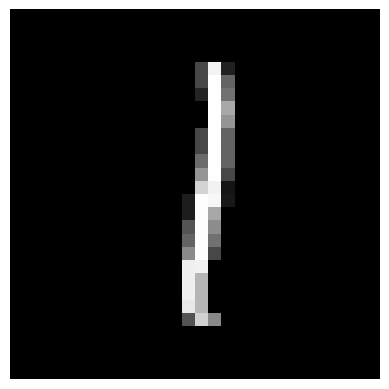

Prediction: 0
Label: 0


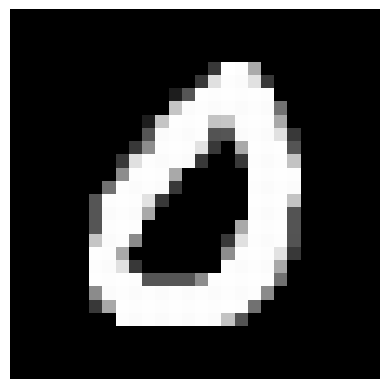

Prediction: 5
Label: 5


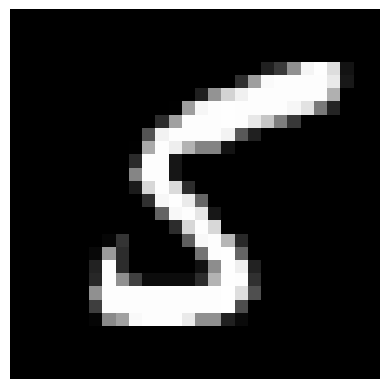

Prediction: 8
Label: 0


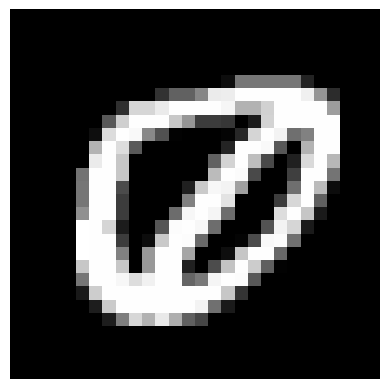

In [22]:
test_prediction(
    index=100,
    X=X_dev,
    Y=Y_dev,
    parameters=parameters
)

test_prediction(
    index=10,
    X=X_dev,
    Y=Y_dev,
    parameters=parameters
)


test_prediction(
    index=14,
    X=X_dev,
    Y=Y_dev,
    parameters=parameters
)

test_prediction(
    index=4,
    X=X_dev,
    Y=Y_dev,
    parameters=parameters
)


test_prediction(
    index=248,
    X=X_dev,
    Y=Y_dev,
    parameters=parameters
)

test_prediction(
    index=42,
    X=X_train,
    Y=Y_train,
    parameters=parameters
)

In [ ]:
AL_dev, _ = forward_propagation(X_dev, parameters)
acc = compute_accuracy(AL_dev, Y_dev_oh)

print(f"Dev Accuracy: {acc*100:.2f}%")

Dev Accuracy: 92.50%
